<h1 align="center">The Battle of Neighborhoods (Week 2)</h1> 

<h3 align="center">Alan Sun</h3> 










## In which London borough should Starbucks open a new coffee shop?

### Introduction/Business problem

Starbucks is a staple of London's high streets, with shops all over the City. As with every chain store, Starbucks is always looking for opportunities and locations to open new shops. This notebook will provide analysis and advice to the Starbucks stakeholders as to where in London they should open up their newest coffee shop. (Please don't sue me for defamation - all companies mentioned in this notebook are fictitious, and likeness to any existing companies is purely coincidental).

Greater London is already very naturally divided into 33 principal divisions - The 32 London boroughs, as well as the City of London. So we will use these divisions to decide which would be the most profitable borough in which to open Starbucks' newest branch. This decision will be based on Foursquare location data for each borough, and the venue types that feature most frequently in each borough.

To give a crude example, it could be the case that people who visit coffee shops also eat at Italian restaurants. Then you would expect that it would be the case that a new coffee shop opened in an area with a high density of Italian restaurants would be more profitable than one opened in an area with very few Italian restaurants.

### Data source and uses

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
import requests

import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


We will scrape data from the following Wikipedia page to find a list of all the London boroughs, along with their latitude and longitude.

In [2]:
boroughs_url = "https://en.wikipedia.org/wiki/List_of_London_boroughs"
r = requests.get(boroughs_url)
r.status_code

200

In [3]:
soup = BeautifulSoup(r.text, 'html.parser')

In [4]:
table = soup.find('table')
table_contents = []
for row in table.findAll('tr')[1:]:
    cell = {} 
    cell['Borough'] = row.findAll('td')[0].text.split(' [')[0].split('[')[0].split('\n')[0]
    coords = row.findAll('td')[8].text.split('/')[1]
    cell['Latitude'] = float(coords.split('°N ')[0][2:])
    cell['Longitude'] = coords.split('°N ')[1][:-4]
    if 'W' in coords:
        cell['Longitude'] = float('-' + cell['Longitude'])
    table_contents.append(cell)

table_contents.append({'Borough': 'City of London', 'Latitude': '51.5155', 'Longitude': '-0.0922'})
# print(table_contents)
df = pd.DataFrame(table_contents)
print(df.shape)
df

(33, 3)


,Borough,Latitude,Longitude
0,Barking and Dagenham,51.5607,0.1557
1,Barnet,51.6252,-0.1517
2,Bexley,51.4549,0.1505
3,Brent,51.5588,-0.2817
4,Bromley,51.4039,0.0198
5,Camden,51.529,-0.1255
6,Croydon,51.3714,-0.0977
7,Ealing,51.513,-0.3089
8,Enfield,51.6538,-0.0799
9,Greenwich,51.4892,0.0648


#### Use geopy library to get the latitude and longitude values of London.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ldn_explorer</em>, as shown below.

In [5]:
address = 'London, LDN'

geolocator = Nominatim(user_agent="ldn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5248187, -0.2031138.


#### Create a map of London with boroughs superimposed on top.

In [6]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

Next, we are going to start utilizing the Foursquare API to explore the boroughs and segment them.

In [7]:
CLIENT_ID = 'Y32PJ1CYGCKQDSSN52JOCNJ4Q4AJWSDBN0N0BHGZBOEDTSHA' # your Foursquare ID
CLIENT_SECRET = 'TO0BICJUNV5SLR3JXZRVZIZSDPU1XXHOSDEBAKUPKU1XXLE3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Y32PJ1CYGCKQDSSN52JOCNJ4Q4AJWSDBN0N0BHGZBOEDTSHA
CLIENT_SECRET:TO0BICJUNV5SLR3JXZRVZIZSDPU1XXHOSDEBAKUPKU1XXLE3


#### Let's explore the first borough in our dataframe.

Get the borough's name.

In [8]:
df.loc[0, 'Borough']

'Barking and Dagenham'

Get the borough's latitude and longitude values.

In [9]:
borough_latitude = df.loc[0, 'Latitude'] # borough latitude value
borough_longitude = df.loc[0, 'Longitude'] # borough longitude value

borough_name = df.loc[0, 'Borough'] # borough name

print('Latitude and longitude values of {} are {}, {}.'.format(borough_name, 
                                                               borough_latitude, 
                                                               borough_longitude))

Latitude and longitude values of Barking and Dagenham are 51.5607, 0.1557.


#### Now, let's get the top 100 venues that are in Barking and Dagenham within a radius of 3000 meters.

In [10]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 3000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    borough_latitude, 
    borough_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=Y32PJ1CYGCKQDSSN52JOCNJ4Q4AJWSDBN0N0BHGZBOEDTSHA&client_secret=TO0BICJUNV5SLR3JXZRVZIZSDPU1XXHOSDEBAKUPKU1XXLE3&v=20180605&ll=51.5607,0.1557&radius=3000&limit=100'

In [11]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60e9b48e76d5ad59a2fd870b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'London',
  'headerFullLocation': 'London',
  'headerLocationGranularity': 'city',
  'totalResults': 77,
  'suggestedBounds': {'ne': {'lat': 51.587700027000025,
    'lng': 0.199049295905574},
   'sw': {'lat': 51.53369997299997, 'lng': 0.11235070409442602}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ac518f8f964a520d6af20e3',
       'name': 'Central Park',
       'location': {'address': 'Wood Ln.',
        'crossStreet': 'Rainham Rd. N.',
        'lat': 51.559560186523925,
        'lng': 0.16198065419715413,
        'labeledLatLngs': [{'label': 'display',
          '

Let's borrow the **get_category_type** function from the Foursquare lab.

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a _pandas_ dataframe.

In [13]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-13-561c05f0fdd1>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Central Park,Park,51.559560,0.161981
1,Lara Grill,Turkish Restaurant,51.562445,0.147178
2,The Eva Hart (Wetherspoon),Pub,51.570460,0.130342
3,Costa Coffee,Coffee Shop,51.576890,0.179497
4,Harrow Lodge Park,Park,51.555648,0.197926


And how many venues were returned by Foursquare?

In [14]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

77 venues were returned by Foursquare.


## Explore Boroughs in London

#### Let's create a function to repeat the same process to all the boroughs in London

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now we write the code to run the above function on each neighborhood and create a new dataframe called _london_venues_.

In [16]:
london_venues = getNearbyVenues(names=df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster
City of London


#### Let's check the size of the resulting dataframe

In [17]:
print(london_venues.shape)
london_venues.head()

(1546, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.5607,0.1557,Central Park,51.559560,0.161981,Park
1,Barking and Dagenham,51.5607,0.1557,Morrisons,51.559774,0.148752,Supermarket
2,Barking and Dagenham,51.5607,0.1557,Crowlands Heath Golf Course,51.562457,0.155818,Golf Course
3,Barking and Dagenham,51.5607,0.1557,Robert Clack Leisure Centre,51.560808,0.152704,Martial Arts School
4,Barking and Dagenham,51.5607,0.1557,Beacontree Heath Leisure Centre,51.560997,0.148932,Gym / Fitness Center


Let's check how many venues were returned for each neighborhood

In [18]:
london_venues.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Barking and Dagenham,7,7,7,7,7,7
Barnet,4,4,4,4,4,4
Bexley,28,28,28,28,28,28
Brent,76,76,76,76,76,76
Bromley,39,39,39,39,39,39
Camden,83,83,83,83,83,83
City of London,100,100,100,100,100,100
Croydon,36,36,36,36,36,36
Ealing,74,74,74,74,74,74


#### Let's find out how many unique categories can be curated from all the returned venues

In [19]:
print('There are {} unique categories.'.format(len(london_venues['Venue Category'].unique())))

There are 221 unique categories.


## Analyze Each Neighborhood

In [20]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add borough column back to dataframe
london_onehot['Borough'] = london_venues['Borough'] 

# move borough column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

# move coffee shops column to the second column
cols = london_onehot.columns.tolist()
i = cols.index('Coffee Shop')
cols = [cols[0]] + [cols[i]] +  cols[1:i] + cols[i+1:]
london_onehot = london_onehot[cols]
london_onehot.head()

,Borough,Coffee Shop,Accessories Store,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Chaat Place,Champagne Bar,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gelato Shop,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lighting Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsagent,Nightclub,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Outdoor Event Space,Outdoor Sculpture,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Public Art,Rafting,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Road,Roof Deck,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoothie Shop,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Train Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Yoga Studio
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

And let's examine the new dataframe size.

In [21]:
london_onehot.shape

(1546, 222)

#### Next, let's group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category

In [22]:
london_grouped = london_onehot.groupby('Borough').mean().reset_index()
# do we want to take the sum rather than the mean here?
# after only considering the frequently occuring venue types,
# we run a linear model, with no. coffee shops as target variable
# no. each of the different other venue types as the feature variables
# From the model, we will check which boroughs have the largest positive training error, i.e. have far fewer coffee shops
# than the linear model predicts.
# The boroughs should be the best boroughs in which to open a new coffee shop.
london_grouped

,Borough,Coffee Shop,Accessories Store,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Chaat Place,Champagne Bar,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gelato Shop,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lighting Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsagent,Nightclub,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Outdoor Event Space,Outdoor Sculpture,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Public Art,Rafting,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Road,Roof Deck,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoothie Shop,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Train Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Yoga Studio
0,Barking and Dagenham,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.142857,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0000

#### Let's confirm the new size

In [23]:
london_grouped.shape

(33, 222)

#### Let's print each borough along with the top 5 most common venues

In [24]:
num_top_venues = 5

for hood in london_grouped['Borough']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking and Dagenham----
                 venue  freq
0                 Pool  0.14
1          Bus Station  0.14
2          Supermarket  0.14
3  Martial Arts School  0.14
4                 Park  0.14


----Barnet----
              venue  freq
0              Café  0.50
1          Bus Stop  0.25
2  Business Service  0.25
3       Coffee Shop  0.00
4            Museum  0.00


----Bexley----
                  venue  freq
0        Clothing Store  0.14
1                   Pub  0.11
2           Supermarket  0.07
3  Fast Food Restaurant  0.07
4              Pharmacy  0.07


----Brent----
                 venue  freq
0          Coffee Shop  0.11
1       Clothing Store  0.08
2                Hotel  0.08
3                  Bar  0.07
4  Sporting Goods Shop  0.05


----Bromley----
                  venue  freq
0        Clothing Store  0.15
1           Coffee Shop  0.13
2                   Bar  0.05
3           Pizza Place  0.05
4  Gym / Fitness Center  0.05


----Camden----
         venue  freq
0

#### Let's put that into a _pandas_ dataframe

First, let's write a function to sort the venues in descending order.

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now, let's create the new dataframe and display the top 10 venues for each borough.

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Supermarket,Pool,Golf Course,Martial Arts School,Park,Gym / Fitness Center,Bus Station,Yoga Studio,Electronics Store,English Restaurant
1,Barnet,Café,Bus Stop,Business Service,Yoga Studio,Cupcake Shop,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
2,Bexley,Clothing Store,Pub,Supermarket,Fast Food Restaurant,Pharmacy,Coffee Shop,Video Game Store,Optical Shop,Furniture / Home Store,Portuguese Restaurant
3,Brent,Coffee Shop,Clothing Store,Hotel,Bar,Sporting Goods Shop,Indian Restaurant,Grocery Store,Sandwich Place,American Restaurant,Burger Joint
4,Bromley,Clothing Store,Coffee Shop,Bar,Burger Joint,Gym / Fitness Center,Pizza Place,Electronics Store,Bookstore,Donut Shop,Pub


We want to get a list of the most common venue types overall.

In [27]:
onehot_summary = london_onehot.describe().transpose().sort_values('mean', ascending=False)
onehot_summary

,count,mean,std,min,25%,50%,75%,max
Coffee Shop,1546.0,0.080854,0.272699,0.0,0.0,0.0,0.0,1.0
Pub,1546.0,0.060802,0.239044,0.0,0.0,0.0,0.0,1.0
Clothing Store,1546.0,0.042044,0.200754,0.0,0.0,0.0,0.0,1.0
Café,1546.0,0.041397,0.199271,0.0,0.0,0.0,0.0,1.0
Hotel,1546.0,0.036223,0.186904,0.0,0.0,0.0,0.0,1.0
Italian Restaurant,1546.0,0.029107,0.168162,0.0,0.0,0.0,0.0,1.0
Bakery,1546.0,0.023933,0.152889,0.0,0.0,0.0,0.0,1.0
Supermarket,1546.0,0.021992,0.146705,0.0,0.0,0.0,0.0,1.0
Grocery Store,1546.0,0.020699,0.142419,0.0,0.0,0.0,0.0,1.0
Indian Restaurant,1546.0,0.020052,0.140223,0.0,0.0,0.0,0.0,1.0


We will consider only the venue types that account for at least 1% of the total venues.

In [28]:
common_venues = []
for index, row in onehot_summary.iterrows():
    if row['mean'] > 0.01:
        common_venues.append(index)
common_venues

['Coffee Shop',
 'Pub',
 'Clothing Store',
 'Café',
 'Hotel',
 'Italian Restaurant',
 'Bakery',
 'Supermarket',
 'Grocery Store',
 'Indian Restaurant',
 'Gym / Fitness Center',
 'Sandwich Place',
 'Pizza Place',
 'Fast Food Restaurant',
 'Burger Joint',
 'Bar',
 'Pharmacy',
 'Restaurant',
 'Park',
 'Portuguese Restaurant',
 'French Restaurant',
 'Department Store']

In [29]:
common_venues_onehot = london_onehot[['Borough']+common_venues]
common_venues_onehot.head()

,Borough,Coffee Shop,Pub,Clothing Store,Café,Hotel,Italian Restaurant,Bakery,Supermarket,Grocery Store,Indian Restaurant,Gym / Fitness Center,Sandwich Place,Pizza Place,Fast Food Restaurant,Burger Joint,Bar,Pharmacy,Restaurant,Park,Portuguese Restaurant,French Restaurant,Department Store
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Barking and Dagenham,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [30]:
common_venues_grouped = common_venues_onehot.groupby('Borough').sum().reset_index()
common_venues_grouped.head()

,Borough,Coffee Shop,Pub,Clothing Store,Café,Hotel,Italian Restaurant,Bakery,Supermarket,Grocery Store,Indian Restaurant,Gym / Fitness Center,Sandwich Place,Pizza Place,Fast Food Restaurant,Burger Joint,Bar,Pharmacy,Restaurant,Park,Portuguese Restaurant,French Restaurant,Department Store
0,Barking and Dagenham,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,Barnet,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bexley,2,3,4,0,1,1,1,2,0,0,0,0,0,2,0,0,2,0,0,1,0,1
3,Brent,8,0,6,2,6,2,2,1,3,3,1,3,1,1,2,5,0,1,0,0,0,0
4,Bromley,5,1,6,1,0,0,1,1,0,0,2,1,2,1,2,2,1,0,0,1,0,1


We now create a linear model on the total number of each venue type in each borough, with the number of coffee shops for each borough as the target variable, and the number of each of the other venue types as the feature variables.

In [31]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(common_venues_grouped[common_venues[1:]])
y = np.asanyarray(common_venues_grouped[['Coffee Shop']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[ 0.22387335  0.64825159 -0.88496872  0.16143611  2.01004479  1.70807595
   0.42994152 -1.34717846 -0.12537916  0.33627839 -0.4714447   0.82989098
   0.39419213 -0.61434848  0.34473277 -0.30703019  1.45495132 -0.14695387
  -1.65830209 -1.47853086 -1.53172644]]


In [32]:
y_hat = regr.predict(common_venues_grouped[common_venues[1:]])
Boroughs_np_array = np.asanyarray(common_venues_grouped[['Borough']])

coffee_df = pd.DataFrame(np.concatenate((Boroughs_np_array, y, y_hat),axis=1),
                        columns = ['Borough','Actual','Predicted'])
coffee_df.set_index('Borough', inplace=True)
coffee_df.head()

,Actual,Predicted
Borough,,
Barking and Dagenham,0,1.12633
Barnet,0,-1.26287
Bexley,2,5.49543
Brent,8,9.13971
Bromley,5,4.0923


We will now add a column which gives the value that we are actually interested in; the difference between the number of predicted coffee shops, and actual coffee shops.

In [33]:
coffee_df['Discrepancy'] = coffee_df['Predicted'] - coffee_df['Actual']
coffee_df.head()

,Actual,Predicted,Discrepancy
Borough,,,
Barking and Dagenham,0,1.12633,1.12633
Barnet,0,-1.26287,-1.26287
Bexley,2,5.49543,3.49543
Brent,8,9.13971,1.13971
Bromley,5,4.0923,-0.907705


In [34]:
coffee_df.sort_values('Discrepancy', inplace=True, ascending=False)
coffee_df

,Actual,Predicted,Discrepancy
Borough,,,
Bexley,2,5.49543,3.49543
Hammersmith and Fulham,3,5.41506,2.41506
Kensington and Chelsea,0,1.93244,1.93244
Lambeth,4,5.18687,1.18687
Brent,8,9.13971,1.13971
Barking and Dagenham,0,1.12633,1.12633
Islington,0,1.04163,1.04163
Tower Hamlets,2,2.84116,0.841162
Merton,1,1.83391,0.833912


So we see that Bexley has the fewest coffee shops compared to how many we would expect to see, so it would be the most favourable borough in which to open a new Starbucks store

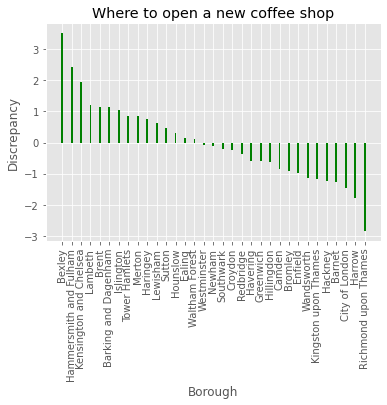

In [35]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
x = coffee_df.index
y = coffee_df['Discrepancy']
x_pos = [4*i for i, _ in enumerate(x)]
plt.bar(x_pos, y, color='green')
plt.xlabel("Borough")
plt.ylabel("Discrepancy")
plt.title("Where to open a new coffee shop")

plt.xticks(x_pos, x, rotation='vertical')

plt.show()

